# Analysis of TextGrad with TextualVerifier

- Comparative analysis for 6 different versiosn of TextGrad & TextualVerifier combination
- Author: Eugenius Mario Situmorang
- Date: June 2025

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
print("=== TextGrad Experiment Analysis ===")
print("Comparing 6 different configurations:\n")
print("1. textgrad-only: Basic TextGrad optimization")
print("2. textgrad-tv-l: TextGrad + TextualVerifier for Loss only")
print("3. textgrad-tv-o-1v: TextGrad + TextualVerifier for Optimizer (1 variant)")
print("4. textgrad-tv-o-3v: TextGrad + TextualVerifier for Optimizer (3 variants)")
print("5. textgrad-tv-lo-1v: TextGrad + TextualVerifier for Loss + Optimizer (1 variant)")
print("6. textgrad-tv-lo-3v: TextGrad + TextualVerifier for Loss + Optimizer (3 variants)")
print("\n" + "="*80 + "\n")

# Load all datasets
datasets = {
    'textgrad-only': 'results/textgrad-only.csv',
    'textgrad-tv-l': 'results/textgrad-tv-l.csv', 
    'textgrad-tv-o-1v': 'results/textgrad-tv-o-1v.csv',
    'textgrad-tv-o-3v': 'results/textgrad-tv-o-3v.csv',
    'textgrad-tv-lo-1v': 'results/textgrad-tv-lo-1v.csv',
    'textgrad-tv-lo-3v': 'results/textgrad-tv-lo-3v.csv'
}

dfs = {}
for name, path in datasets.items():
    try:
        df = pd.read_csv(path)
        df['method'] = name
        dfs[name] = df
        print(f"✓ Loaded {name}: {len(df)} samples")
    except FileNotFoundError:
        print(f"✗ File not found: {path}")
    except Exception as e:
        print(f"✗ Error loading {name}: {str(e)}")

print(f"\nSuccessfully loaded {len(dfs)} datasets")

=== TextGrad Experiment Analysis ===
Comparing 6 different configurations:

1. textgrad-only: Basic TextGrad optimization
2. textgrad-tv-l: TextGrad + TextualVerifier for Loss only
3. textgrad-tv-o-1v: TextGrad + TextualVerifier for Optimizer (1 variant)
4. textgrad-tv-o-3v: TextGrad + TextualVerifier for Optimizer (3 variants)
5. textgrad-tv-lo-1v: TextGrad + TextualVerifier for Loss + Optimizer (1 variant)
6. textgrad-tv-lo-3v: TextGrad + TextualVerifier for Loss + Optimizer (3 variants)


✓ Loaded textgrad-only: 412 samples
✓ Loaded textgrad-tv-l: 412 samples
✓ Loaded textgrad-tv-o-1v: 412 samples
✓ Loaded textgrad-tv-o-3v: 412 samples
✓ Loaded textgrad-tv-lo-1v: 412 samples
✓ Loaded textgrad-tv-lo-3v: 412 samples

Successfully loaded 6 datasets


## METRIC DEFINITIONS

In [8]:
def extract_answer_from_solution(solution_text):
    """Extract the final answer (A, B, C, or D) from solution text"""
    if pd.isna(solution_text) or solution_text == "":
        return None
    
    # Look for "Answer: X" pattern at the end
    import re
    answer_pattern = r'Answer:\s*([ABCD])'
    matches = re.findall(answer_pattern, str(solution_text))
    if matches:
        return matches[-1]  # Take the last occurrence
    
    # Alternative: look for just a single letter at the end
    letter_pattern = r'\b([ABCD])\s*$'
    matches = re.findall(letter_pattern, str(solution_text).strip())
    if matches:
        return matches[-1]
    
    return None

def calculate_accuracy(df):
    """Calculate accuracy based on correct vs final answer"""
    if 'final_solution_answer' not in df.columns:
        return 0.0
    
    # Extract answers from both columns
    df['extracted_final'] = df['final_solution_answer'].apply(extract_answer_from_solution)
    df['extracted_correct'] = df['correct_answer'].apply(lambda x: x.strip() if pd.notna(x) else None)
    
    # Count correct answers
    correct_mask = (df['extracted_final'] == df['extracted_correct']) & df['extracted_final'].notna()
    return correct_mask.sum() / len(df) if len(df) > 0 else 0.0

def analyze_method_performance(method_df):
    """Analyze performance metrics for a single method"""
    metrics = {}
    
    # Basic success metrics
    total_samples = len(method_df)
    successful_samples = method_df['success'].sum() if 'success' in method_df.columns else 0
    failed_samples = total_samples - successful_samples
    
    metrics['total_samples'] = total_samples
    metrics['successful_samples'] = successful_samples
    metrics['failed_samples'] = failed_samples
    metrics['success_rate'] = successful_samples / total_samples if total_samples > 0 else 0.0
    
    # Accuracy (for successful samples only)
    if successful_samples > 0:
        successful_df = method_df[method_df['success'] == True].copy()
        metrics['accuracy'] = calculate_accuracy(successful_df)
        metrics['accuracy_overall'] = calculate_accuracy(method_df)
    else:
        metrics['accuracy'] = 0.0
        metrics['accuracy_overall'] = 0.0
    
    # Performance metrics (for successful samples)
    if successful_samples > 0:
        perf_df = method_df[method_df['success'] == True]
        
        metrics['avg_processing_time'] = perf_df['processing_time_ms'].mean()
        metrics['median_processing_time'] = perf_df['processing_time_ms'].median()
        metrics['std_processing_time'] = perf_df['processing_time_ms'].std()
        
        metrics['avg_llm_calls'] = perf_df['total_llm_calls'].mean()
        metrics['median_llm_calls'] = perf_df['total_llm_calls'].median()
        metrics['std_llm_calls'] = perf_df['total_llm_calls'].std()
        
        metrics['avg_input_tokens'] = perf_df['total_input_tokens'].mean()
        metrics['avg_output_tokens'] = perf_df['total_output_tokens'].mean()
        metrics['avg_total_tokens'] = metrics['avg_input_tokens'] + metrics['avg_output_tokens']
        
    else:
        # Set defaults for failed methods
        for key in ['avg_processing_time', 'median_processing_time', 'std_processing_time',
                   'avg_llm_calls', 'median_llm_calls', 'std_llm_calls',
                   'avg_input_tokens', 'avg_output_tokens', 'avg_total_tokens']:
            metrics[key] = 0.0
    
    return metrics

## PERFORMANCE ANALYSIS

In [9]:
print("PERFORMANCE ANALYSIS")
print("="*50)

# Analyze each method
method_results = {}
for method_name, df in dfs.items():
    print(f"\nAnalyzing {method_name}...")
    metrics = analyze_method_performance(df)
    method_results[method_name] = metrics
    
    print(f"  • Total samples: {metrics['total_samples']}")
    print(f"  • Success rate: {metrics['success_rate']:.1%}")
    print(f"  • Accuracy (successful only): {metrics['accuracy']:.1%}")
    print(f"  • Overall accuracy: {metrics['accuracy_overall']:.1%}")
    if metrics['successful_samples'] > 0:
        print(f"  • Avg LLM calls: {metrics['avg_llm_calls']:.1f}")
        print(f"  • Avg processing time: {metrics['avg_processing_time']:.1f}ms")
        print(f"  • Avg total tokens: {metrics['avg_total_tokens']:.0f}")

# Create summary dataframe
summary_df = pd.DataFrame(method_results).T
summary_df = summary_df.round(3)

print(f"\n{'='*80}")
print("SUMMARY TABLE")
print("="*80)
print(summary_df[['success_rate', 'accuracy_overall', 'avg_llm_calls', 
                  'avg_processing_time', 'avg_total_tokens']].to_string())

PERFORMANCE ANALYSIS

Analyzing textgrad-only...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 68.2%
  • Overall accuracy: 68.2%
  • Avg LLM calls: 0.0
  • Avg processing time: 0.0ms
  • Avg total tokens: 0

Analyzing textgrad-tv-l...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 69.2%
  • Overall accuracy: 69.2%
  • Avg LLM calls: 1.0
  • Avg processing time: 7.8ms
  • Avg total tokens: 391

Analyzing textgrad-tv-o-1v...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 65.0%
  • Overall accuracy: 65.0%
  • Avg LLM calls: 9.6
  • Avg processing time: 67.1ms
  • Avg total tokens: 7754

Analyzing textgrad-tv-o-3v...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 66.7%
  • Overall accuracy: 66.7%
  • Avg LLM calls: 35.3
  • Avg processing time: 122630.1ms
  • Avg total tokens: 24065

Analyzing textgrad-tv-lo-1v...
  • Total samples: 412
  • Success rate: 99.0

## VISUALIZATIONS

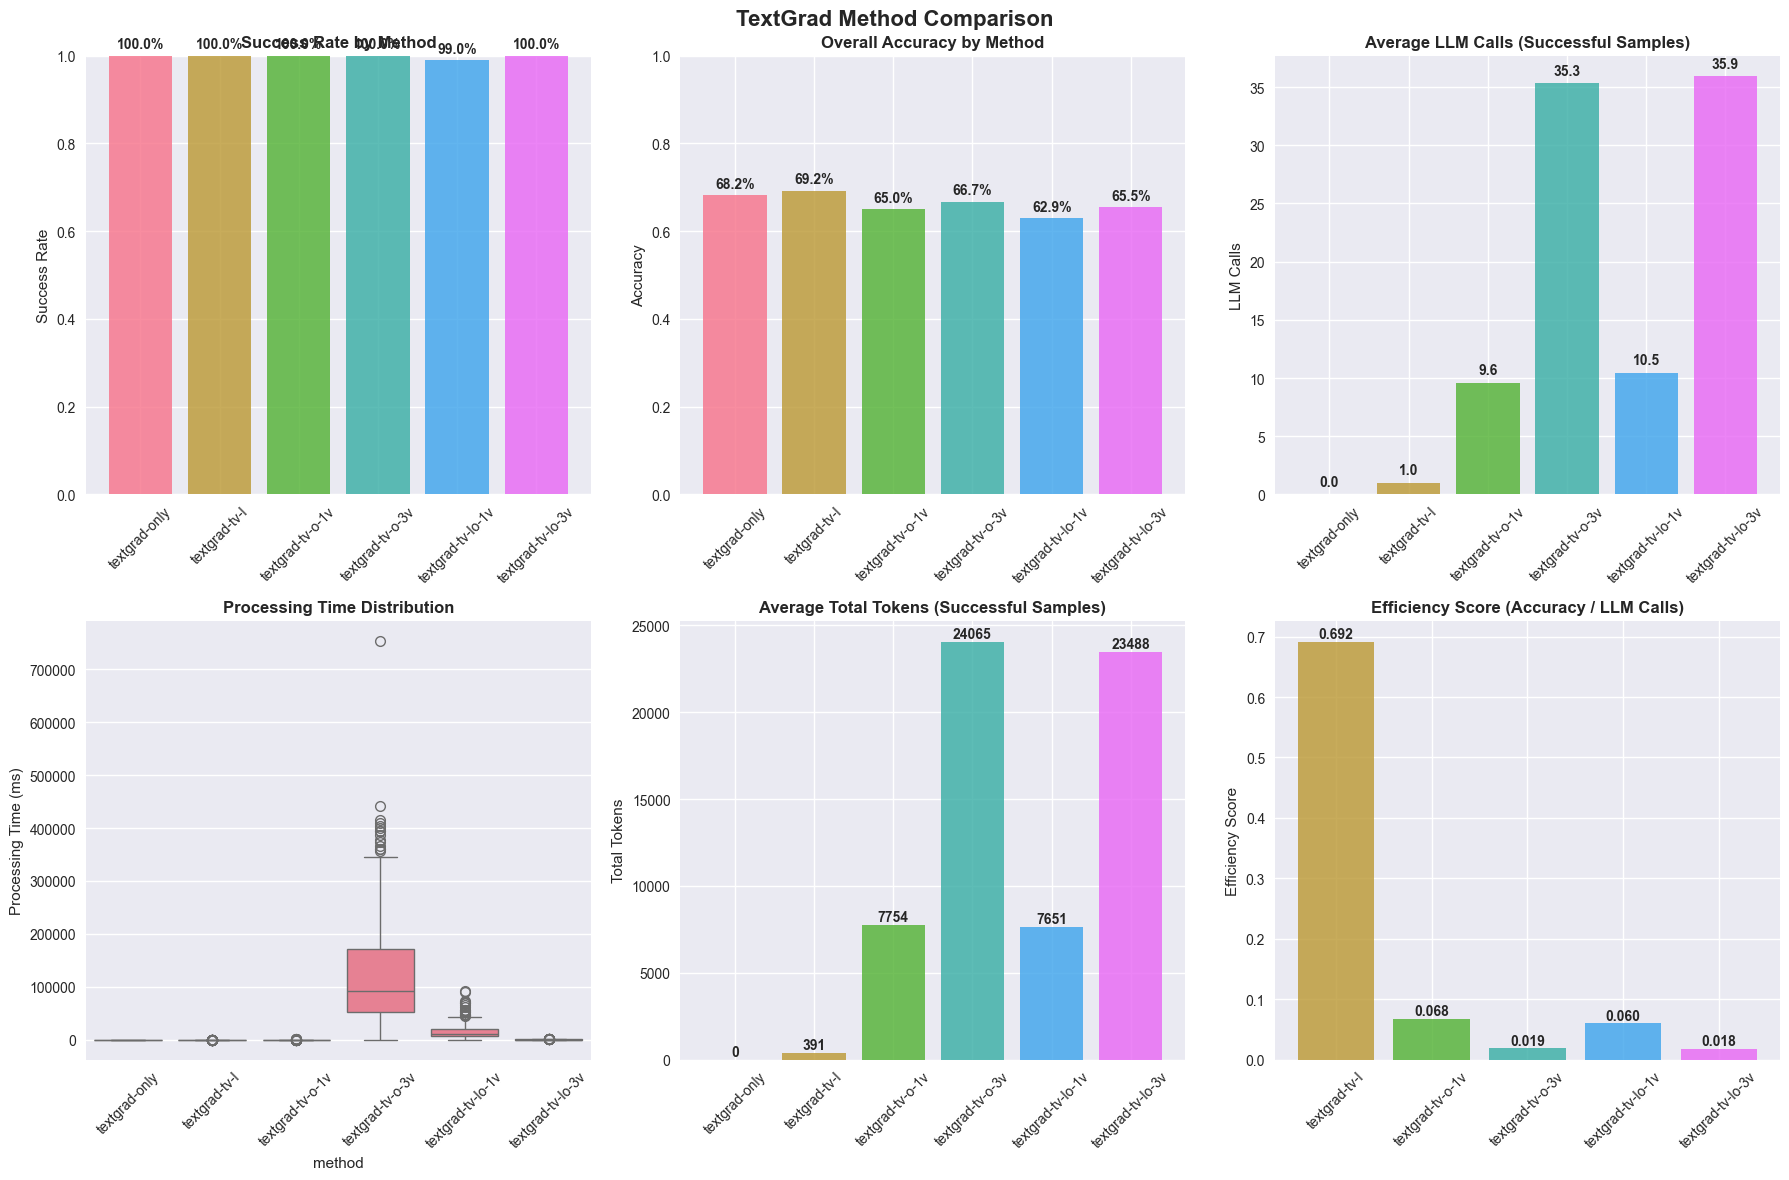

In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('TextGrad Method Comparison', fontsize=16, fontweight='bold')

# 1. Success Rate Comparison
ax1 = axes[0, 0]
methods = list(summary_df.index)
success_rates = summary_df['success_rate'].values
colors = sns.color_palette("husl", len(methods))

bars1 = ax1.bar(methods, success_rates, color=colors, alpha=0.8)
ax1.set_title('Success Rate by Method', fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.0)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, rate in zip(bars1, success_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Overall Accuracy Comparison
ax2 = axes[0, 1]
accuracy_rates = summary_df['accuracy_overall'].values
bars2 = ax2.bar(methods, accuracy_rates, color=colors, alpha=0.8)
ax2.set_title('Overall Accuracy by Method', fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.0)
ax2.tick_params(axis='x', rotation=45)

for bar, acc in zip(bars2, accuracy_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. Average LLM Calls (for successful samples only)
ax3 = axes[0, 2]
# Only plot methods with successful samples
successful_methods = []
successful_llm_calls = []
successful_colors = []

for i, (method, metrics) in enumerate(method_results.items()):
    if metrics['successful_samples'] > 0:
        successful_methods.append(method)
        successful_llm_calls.append(metrics['avg_llm_calls'])
        successful_colors.append(colors[i])

if successful_methods:
    bars3 = ax3.bar(successful_methods, successful_llm_calls, color=successful_colors, alpha=0.8)
    ax3.set_title('Average LLM Calls (Successful Samples)', fontweight='bold')
    ax3.set_ylabel('LLM Calls')
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, calls in zip(bars3, successful_llm_calls):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{calls:.1f}', ha='center', va='bottom', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No successful samples', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Average LLM Calls (Successful Samples)', fontweight='bold')

# 4. Processing Time Distribution (for methods with successful samples)
ax4 = axes[1, 0]
processing_times = []
method_labels = []

for method_name, df in dfs.items():
    if method_name in method_results and method_results[method_name]['successful_samples'] > 0:
        successful_df = df[df['success'] == True]
        if len(successful_df) > 0:
            processing_times.extend(successful_df['processing_time_ms'].values)
            method_labels.extend([method_name] * len(successful_df))

if processing_times:
    time_df = pd.DataFrame({'time': processing_times, 'method': method_labels})
    sns.boxplot(data=time_df, x='method', y='time', ax=ax4)
    ax4.set_title('Processing Time Distribution', fontweight='bold')
    ax4.set_ylabel('Processing Time (ms)')
    ax4.tick_params(axis='x', rotation=45)
else:
    ax4.text(0.5, 0.5, 'No timing data available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Processing Time Distribution', fontweight='bold')

# 5. Token Usage Comparison
ax5 = axes[1, 1]
if successful_methods:
    total_tokens = [method_results[method]['avg_total_tokens'] for method in successful_methods]
    bars5 = ax5.bar(successful_methods, total_tokens, color=successful_colors, alpha=0.8)
    ax5.set_title('Average Total Tokens (Successful Samples)', fontweight='bold')
    ax5.set_ylabel('Total Tokens')
    ax5.tick_params(axis='x', rotation=45)
    
    for bar, tokens in zip(bars5, total_tokens):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 50,
                 f'{tokens:.0f}', ha='center', va='bottom', fontweight='bold')
else:
    ax5.text(0.5, 0.5, 'No token data available', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Average Total Tokens (Successful Samples)', fontweight='bold')

# 6. Efficiency Score (Accuracy per LLM call)
ax6 = axes[1, 2]
if successful_methods:
    efficiency_scores = []
    efficiency_labels = []
    efficiency_colors = []
    
    for i, method in enumerate(successful_methods):
        metrics = method_results[method]
        if metrics['avg_llm_calls'] > 0:
            # Efficiency = Overall Accuracy / Average LLM Calls
            efficiency = metrics['accuracy_overall'] / metrics['avg_llm_calls']
            efficiency_scores.append(efficiency)
            efficiency_labels.append(method)
            efficiency_colors.append(successful_colors[i])
    
    if efficiency_scores:
        bars6 = ax6.bar(efficiency_labels, efficiency_scores, color=efficiency_colors, alpha=0.8)
        ax6.set_title('Efficiency Score (Accuracy / LLM Calls)', fontweight='bold')
        ax6.set_ylabel('Efficiency Score')
        ax6.tick_params(axis='x', rotation=45)
        
        for bar, eff in zip(bars6, efficiency_scores):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                     f'{eff:.3f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'No efficiency data', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Efficiency Score (Accuracy / LLM Calls)', fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No efficiency data available', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Efficiency Score (Accuracy / LLM Calls)', fontweight='bold')

plt.tight_layout()
plt.show()

## DETAILED METRICS TABLE

In [11]:
print(f"\n{'='*80}")
print("DETAILED METRICS TABLE")
print("="*80)

detailed_metrics = []
for method_name, metrics in method_results.items():
    row = {
        'Method': method_name,
        'Total Samples': metrics['total_samples'],
        'Success Rate': f"{metrics['success_rate']:.1%}",
        'Overall Accuracy': f"{metrics['accuracy_overall']:.1%}",
        'Accuracy (Success Only)': f"{metrics['accuracy']:.1%}",
        'Avg LLM Calls': f"{metrics['avg_llm_calls']:.1f}",
        'Median LLM Calls': f"{metrics['median_llm_calls']:.1f}",
        'Avg Processing Time (ms)': f"{metrics['avg_processing_time']:.1f}",
        'Avg Input Tokens': f"{metrics['avg_input_tokens']:.0f}",
        'Avg Output Tokens': f"{metrics['avg_output_tokens']:.0f}",
        'Avg Total Tokens': f"{metrics['avg_total_tokens']:.0f}",
    }
    detailed_metrics.append(row)

detailed_df = pd.DataFrame(detailed_metrics)
print(detailed_df.to_string(index=False))


DETAILED METRICS TABLE
           Method  Total Samples Success Rate Overall Accuracy Accuracy (Success Only) Avg LLM Calls Median LLM Calls Avg Processing Time (ms) Avg Input Tokens Avg Output Tokens Avg Total Tokens
    textgrad-only            412       100.0%            68.2%                   68.2%           0.0              0.0                      0.0                0                 0                0
    textgrad-tv-l            412       100.0%            69.2%                   69.2%           1.0              1.0                      7.8              338                53              391
 textgrad-tv-o-1v            412       100.0%            65.0%                   65.0%           9.6              8.0                     67.1             7300               454             7754
 textgrad-tv-o-3v            412       100.0%            66.7%                   66.7%          35.3             29.0                 122630.1            22581              1483            24065
t

## RECOMMENDATIONS

In [12]:
print(f"\n{'='*80}")
print("ANALYSIS & RECOMMENDATIONS")
print("="*80)

# Find best performing methods
best_success_rate = max(method_results.items(), key=lambda x: x[1]['success_rate'])
best_accuracy = max(method_results.items(), key=lambda x: x[1]['accuracy_overall'])

successful_methods_results = {k: v for k, v in method_results.items() if v['successful_samples'] > 0}
if successful_methods_results:
    best_efficiency = min(successful_methods_results.items(), 
                         key=lambda x: x[1]['avg_llm_calls'] if x[1]['avg_llm_calls'] > 0 else float('inf'))
    best_speed = min(successful_methods_results.items(), 
                    key=lambda x: x[1]['avg_processing_time'])

print(f"\n🏆 BEST PERFORMERS:")
print(f"  • Highest Success Rate: {best_success_rate[0]} ({best_success_rate[1]['success_rate']:.1%})")
print(f"  • Highest Overall Accuracy: {best_accuracy[0]} ({best_accuracy[1]['accuracy_overall']:.1%})")

if successful_methods_results:
    print(f"  • Most Efficient (fewest LLM calls): {best_efficiency[0]} ({best_efficiency[1]['avg_llm_calls']:.1f} calls)")
    print(f"  • Fastest Processing: {best_speed[0]} ({best_speed[1]['avg_processing_time']:.1f}ms)")

print(f"\n📊 KEY INSIGHTS:")

# Analyze TextualVerifier impact
tv_methods = [m for m in method_results.keys() if 'tv' in m and method_results[m]['successful_samples'] > 0]
non_tv_methods = [m for m in method_results.keys() if 'tv' not in m and method_results[m]['successful_samples'] > 0]

if tv_methods and non_tv_methods:
    avg_accuracy_tv = np.mean([method_results[m]['accuracy_overall'] for m in tv_methods])
    avg_accuracy_non_tv = np.mean([method_results[m]['accuracy_overall'] for m in non_tv_methods])
    
    avg_calls_tv = np.mean([method_results[m]['avg_llm_calls'] for m in tv_methods])
    avg_calls_non_tv = np.mean([method_results[m]['avg_llm_calls'] for m in non_tv_methods])
    
    print(f"  • TextualVerifier Impact:")
    print(f"    - Accuracy: TV methods {avg_accuracy_tv:.1%} vs Non-TV {avg_accuracy_non_tv:.1%}")
    print(f"    - LLM Calls: TV methods {avg_calls_tv:.1f} vs Non-TV {avg_calls_non_tv:.1f}")

# Analyze component-specific TextualVerifier impact
loss_only_methods = [m for m in method_results.keys() if 'tv-l' in m and method_results[m]['successful_samples'] > 0]
optimizer_methods = [m for m in method_results.keys() if 'tv-o' in m and method_results[m]['successful_samples'] > 0]
combined_methods = [m for m in method_results.keys() if 'tv-lo' in m and method_results[m]['successful_samples'] > 0]

if loss_only_methods:
    avg_acc_loss = np.mean([method_results[m]['accuracy_overall'] for m in loss_only_methods])
    print(f"  • Loss-only TextualVerifier: {avg_acc_loss:.1%} accuracy")

if optimizer_methods:
    avg_acc_opt = np.mean([method_results[m]['accuracy_overall'] for m in optimizer_methods])
    print(f"  • Optimizer-only TextualVerifier: {avg_acc_opt:.1%} accuracy")

if combined_methods:
    avg_acc_combined = np.mean([method_results[m]['accuracy_overall'] for m in combined_methods])
    print(f"  • Combined Loss+Optimizer TextualVerifier: {avg_acc_combined:.1%} accuracy")

# Analyze variant impact
variant_1_methods = [m for m in method_results.keys() if '1v' in m and method_results[m]['successful_samples'] > 0]
variant_3_methods = [m for m in method_results.keys() if '3v' in m and method_results[m]['successful_samples'] > 0]

if variant_1_methods and variant_3_methods:
    avg_accuracy_1v = np.mean([method_results[m]['accuracy_overall'] for m in variant_1_methods])
    avg_accuracy_3v = np.mean([method_results[m]['accuracy_overall'] for m in variant_3_methods])
    
    print(f"  • Multi-variant Impact:")
    print(f"    - 1 variant: {avg_accuracy_1v:.1%} accuracy")
    print(f"    - 3 variants: {avg_accuracy_3v:.1%} accuracy")

print(f"\n💡 RECOMMENDATIONS:")
print(f"  1. For highest success rate: Use {best_success_rate[0]}")
print(f"  2. For best accuracy: Use {best_accuracy[0]}")
if successful_methods_results:
    print(f"  3. For efficiency: Use {best_efficiency[0]} (good accuracy with fewer LLM calls)")
    print(f"  4. For speed: Use {best_speed[0]} (fastest processing)")

print(f"\n🔍 TEXTUALVERIFIER ANALYSIS:")
if tv_methods and non_tv_methods:
    improvement = avg_accuracy_tv - avg_accuracy_non_tv
    cost_increase = avg_calls_tv - avg_calls_non_tv
    print(f"  • TextualVerifier provides {improvement:+.1%} accuracy improvement")
    print(f"  • At cost of {cost_increase:+.1f} additional LLM calls per sample")
    print(f"  • ROI: {improvement/cost_increase:.3f} accuracy points per additional call" if cost_increase > 0 else "")

print(f"\n⚠️  NOTE: Methods with 0% success rate likely had implementation issues")
print(f"    and should be debugged before production use.")

print(f"\n📋 METHODOLOGY INSIGHTS:")
print(f"  • TextualVerifier (TV) adds verification layers to TextGrad optimization")
print(f"  • 'L' variants verify loss calculations")
print(f"  • 'O' variants verify optimizer steps") 
print(f"  • 'LO' variants verify both loss and optimizer")
print(f"  • Multiple variants (1v vs 3v) test robustness through repetition")

print(f"\n{'='*80}")
print("Analysis Complete!")
print("="*80)


ANALYSIS & RECOMMENDATIONS

🏆 BEST PERFORMERS:
  • Highest Success Rate: textgrad-only (100.0%)
  • Highest Overall Accuracy: textgrad-tv-l (69.2%)
  • Most Efficient (fewest LLM calls): textgrad-tv-l (1.0 calls)
  • Fastest Processing: textgrad-only (0.0ms)

📊 KEY INSIGHTS:
  • TextualVerifier Impact:
    - Accuracy: TV methods 65.9% vs Non-TV 68.2%
    - LLM Calls: TV methods 18.5 vs Non-TV 0.0
  • Loss-only TextualVerifier: 65.9% accuracy
  • Optimizer-only TextualVerifier: 65.9% accuracy
  • Combined Loss+Optimizer TextualVerifier: 64.2% accuracy
  • Multi-variant Impact:
    - 1 variant: 64.0% accuracy
    - 3 variants: 66.1% accuracy

💡 RECOMMENDATIONS:
  1. For highest success rate: Use textgrad-only
  2. For best accuracy: Use textgrad-tv-l
  3. For efficiency: Use textgrad-tv-l (good accuracy with fewer LLM calls)
  4. For speed: Use textgrad-only (fastest processing)

🔍 TEXTUALVERIFIER ANALYSIS:
  • TextualVerifier provides -2.3% accuracy improvement
  • At cost of +18.5 add